In [ ]:
# Import required libraries for data manipulation, geospatial analysis, and visualization
import pandas as pd
import geopandas as gpd
import ast
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point
import glob
import numpy as np
import matplotlib.ticker as mticker
from matplotlib.colors import LinearSegmentedColormap



In [ ]:
# Set the property type and time period for analysis
property_type = 'Apartments' # Options: 'Houses', 'Apartments', 'Offices'
# Note: Some house data may have incorrect coordinates, especially for certain neighborhoods
year = 2025
quarter = 1  # Desired quarter for analysis (1, 2, 3, or 4)


In [ ]:
# Find all CSV files for the selected property type and city
csv_files = glob.glob(f'../../../data/{property_type}/listings_data_m2_medellin*.csv')

# Read and concatenate all CSV files into a single DataFrame for analysis
df = pd.concat((pd.read_csv(f) for f in csv_files), ignore_index=True)

In [ ]:
# Convert 'Extraction Date' column to datetime format if not already
df['Extraction Date'] = pd.to_datetime(df['Extraction Date'])

# Filter data for the selected quarter and year
start_month = 3 * (quarter - 1) + 1
end_month = start_month + 2
mask = (
    (df['Extraction Date'].dt.year == year) &
    (df['Extraction Date'].dt.month >= start_month) &
    (df['Extraction Date'].dt.month <= end_month)
)
df =  df[mask]


In [ ]:
# Sort the DataFrame by extraction date (most recent first)
df.sort_values('Extraction Date', ascending=False, inplace=True)

# Remove duplicate property listings, keeping only the most recent entry for each propertyId
df.drop_duplicates(subset='propertyId', inplace=True, keep='first')

In [ ]:
# Calculate price per square meter for each property
df['price_per_m2'] = df['salePrice'] / df['area']

# Extract longitude and latitude from the 'coordinates' column
df['coordinates'] = df['coordinates'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['lon'] = df['coordinates'].apply(lambda x: x.get('lon') if isinstance(x, dict) else None)
df['lat'] = df['coordinates'].apply(lambda x: x.get('lat') if isinstance(x, dict) else None)

# Remove rows with missing or zero coordinates
df = df[(df['lon'] != 0.0) & (df['lat'] != 0.0)]
df_map = df.dropna(subset=['lon', 'lat'])



In [ ]:
# Load the shapefile for neighborhoods (barrios) and corregimientos
# These files contain the geographic boundaries for spatial analysis
gdf = gpd.read_file('shp_barrios_y_veredas/barrios_y_veredas.shp')
gdf_corregimientos = gpd.read_file('shp_comunas_y_corregimientos_/comunas_y_corregimientos_.shp')

# Filter out rows with missing neighborhood names
gdf = gdf[gdf['nombre'].notna()]



In [ ]:
# Get the geometry for 'El Poblado' from the corregimientos shapefile
el_poblado_geom = gdf_corregimientos[gdf_corregimientos['nombre'] == 'El Poblado']['geometry'].iloc[0]

# Filter neighborhoods (barrios) that are within 'El Poblado' or are specific named areas
# This creates a GeoDataFrame for the sub-neighborhoods of El Poblado
gdf_el_poblado = gdf[gdf.within(el_poblado_geom) | 
                    (gdf['nombre'] == 'La Aguacatala') |
                    (gdf['nombre'] == 'Santa María de Los Ángeles') |
                    (gdf['nombre'] == 'El Tesoro') ].copy()


In [ ]:
# Ensure the GeoDataFrame is in the same CRS as the coordinates (EPSG:4326)
gdf_4326 = gdf_el_poblado.to_crs(epsg=4326)

# Create a geometry column in df_map for spatial operations
df_map['geometry'] = df_map.apply(lambda row: Point(row['lon'], row['lat']), axis=1)

# Convert df_map to a GeoDataFrame for spatial join
gdf_points = gpd.GeoDataFrame(df_map, geometry='geometry', crs='EPSG:4326')

# Perform a spatial join to assign each property to a neighborhood
gdf_points = gpd.sjoin(gdf_points, gdf_4326[['nombre', 'geometry']], how='left', predicate='within')

# Add the neighborhood name from the shapefile as a new column in df_map
df_map['neighbourhood_from_shape'] = gdf_points['nombre']

# Calculate the Semi-Interquartile Range (SIQR) for each neighborhood
q1 = df_map.groupby('neighbourhood_from_shape')['salePrice'].quantile(0.25)
q3 = df_map.groupby('neighbourhood_from_shape')['salePrice'].quantile(0.75)
siqr_by_neigh = (q3 - q1) / 2

# Map SIQR to the gdf_4326 GeoDataFrame
gdf_4326['siqr'] = gdf_4326['nombre'].map(siqr_by_neigh)

# Calculate the number of properties per neighborhood
count_by_neigh = df_map.groupby('neighbourhood_from_shape')['salePrice'].count()
gdf_4326['num_properties'] = gdf_4326['nombre'].map(count_by_neigh).fillna(0).astype(int)

# Map the average and median price to the gdf_4326 GeoDataFrame based on 'nombre'
gdf_4326['avg_price'] = gdf_4326['nombre'].map(avg_price_by_neigh)
gdf_4326['median_price'] = gdf_4326['nombre'].map(median_price_by_neigh)

# If the number of properties is less than 5, set avg_price and median_price to NaN for reliability
min_properties = 5
gdf_4326.loc[gdf_4326['num_properties'] < min_properties, 'avg_price'] = np.nan
gdf_4326.loc[gdf_4326['num_properties'] < min_properties, 'median_price'] = np.nan



/tmp/ipykernel_701190/1886659470.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_map['geometry'] = df_map.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
/tmp/ipykernel_701190/1886659470.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_map['neighbourhood_from_shape'] = gdf_points['nombre']


In [ ]:
# Calculate average and median sale price for each neighborhood in df_map
avg_price_by_neigh = df_map.groupby('neighbourhood_from_shape')['salePrice'].mean()
median_price_by_neigh = df_map.groupby('neighbourhood_from_shape')['salePrice'].median()

# Calculate the Semi-Interquartile Range (SIQR) for each neighbourhood
q1 = df_map.groupby('neighbourhood_from_shape')['salePrice'].quantile(0.25)
q3 = df_map.groupby('neighbourhood_from_shape')['salePrice'].quantile(0.75)
siqr_by_neigh = (q3 - q1) / 2

# Map SIQR to the gdf_4326 GeoDataFrame
gdf_4326['siqr'] = gdf_4326['nombre'].map(siqr_by_neigh)


# Calculate the number of properties per neighbourhood
count_by_neigh = df_map.groupby('neighbourhood_from_shape')['salePrice'].count()
gdf_4326['num_properties'] = gdf_4326['nombre'].map(count_by_neigh).fillna(0).astype(int)

# Map the average price to the gdf_4326 GeoDataFrame based on 'nombre'
gdf_4326['avg_price'] = gdf_4326['nombre'].map(avg_price_by_neigh)
gdf_4326['median_price'] = gdf_4326['nombre'].map(median_price_by_neigh)


# If the number of properties is less than 5, make the avg_price equal to nan
min_properties = 5
gdf_4326.loc[gdf_4326['num_properties'] < min_properties, 'avg_price'] = np.nan
gdf_4326.loc[gdf_4326['num_properties'] < min_properties, 'median_price'] = np.nan




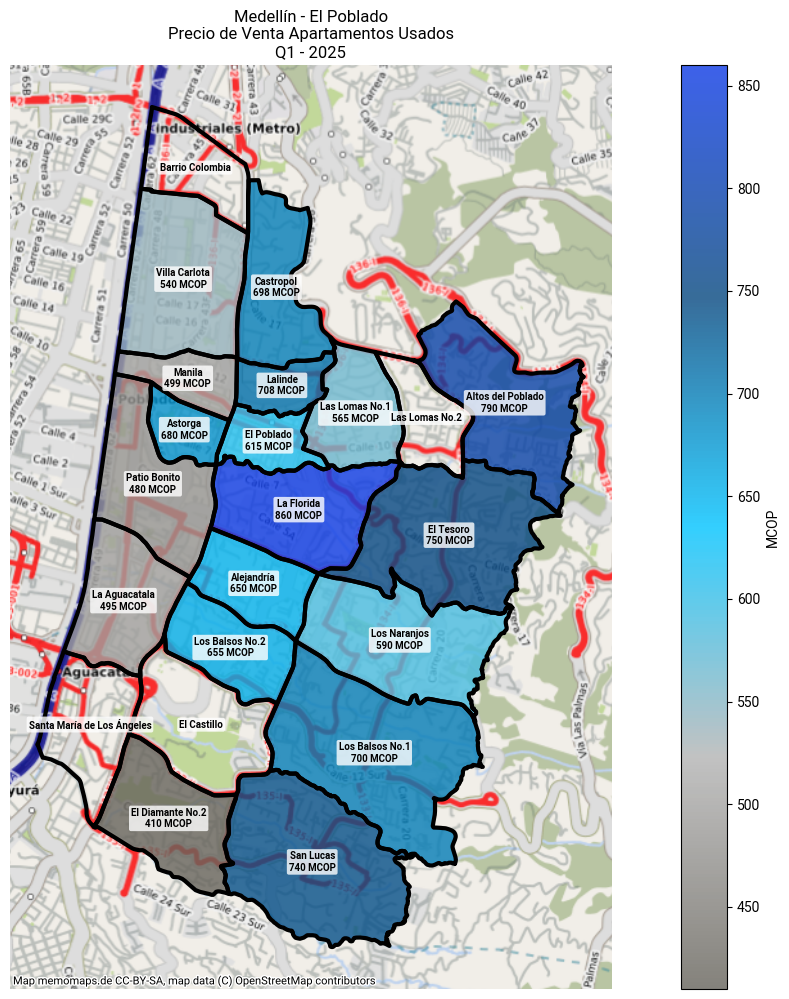

In [ ]:
# Set the map provider for the basemap
map_provider = 'OPNVKarte'

# Set the font to Roboto for the entire figure
plt.rcParams['font.family'] = 'Roboto'

# Create the figure and axis for plotting
fig, ax = plt.subplots(figsize=(18, 12))

# Filter neighborhoods with valid (non-NaN, non-zero) median prices
gdf_4326_valid = gdf_4326[gdf_4326['median_price'].notna() & (gdf_4326['median_price'] != 0)]

# Define a custom color palette for the map
colors = [
    (102/255, 99/255, 91/255),    # GrayDark
    (179/255, 179/255, 179/255), # GrayLight
    (0/255, 195/255, 255/255),   # BlueLight
    (5/255, 71/255, 127/255),    # BlueDarkDark
    (12/255, 58/255, 229/255),    # BlueDark
]

# Create the colormap from the custom color list
my_cmap = LinearSegmentedColormap.from_list("my_custom_colormap", colors)

# Set the transparency
alpha_value = 0.8


# Plot the valid neighborhoods colored by median price
plot = gdf_4326_valid.plot(
    column='median_price', ax=ax, legend=True, cmap=my_cmap, edgecolor='k', alpha=alpha_value
)

# Draw the edges of all neighborhoods (including those without data)
gdf_4326.plot(facecolor='none', ax=ax, edgecolor='k', linewidth=3)

# Add the basemap tiles to the plot
source = ctx.providers[map_provider]
ctx.add_basemap(ax, crs=gdf_4326.crs.to_string(), source=source)

# Set the plot title and remove axis
if property_type == 'Apartments':
    property_type_label = 'Apartamentos Usados'
elif property_type == 'Houses':
    property_type_label = 'Casas Usadas'
elif property_type == 'Offices':
    property_type_label = 'Oficinas Usadas'

plt.title(f'Medellín - El Poblado\nPrecio de Venta {property_type_label}\nQ{quarter} - {year}')
plt.axis('off')

# Format the colorbar to show values in millions of COP
cbar = plot.get_figure().axes[-1]
cbar.set_ylabel('MCOP')
cbar.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x/1e6:.0f}'))
for c in cbar.collections:
    c.set_alpha(alpha_value)

# Annotate each neighborhood with its name and median price (if available)
for idx, row in gdf_4326.iterrows():
    centroid = row['geometry'].centroid
    neighbourhood_name = row['nombre']
    median_price = row['median_price']
    if not np.isnan(median_price) and median_price != 0:
        value = median_price / 1e6
        label = f'{neighbourhood_name}\n{value:,.0f} MCOP'
    else:
        label = f'{neighbourhood_name}'
    ax.annotate(
        label,
        (centroid.x, centroid.y),
        color='black',
        fontsize=7,
        ha='center',
        va='center',
        fontweight='bold',
        bbox=dict(facecolor='white', alpha=alpha_value, edgecolor='none', boxstyle='round,pad=0.2')
    )

# Display the plot
plt.show()


In [ ]:
# Descubre cómo varían los precios medianos de venta de apartamentos en los barrios de El Poblado, Medellín 🏙️📊. Este mapa muestra las diferencias entre sectores durante el primer trimestre de 2025. ¿En qué barrio te gustaría vivir? #Medellín #ElPoblado #Inmobiliaria #Datos #Vivienda #RealEstate #DataViz

